# Derivatives

This notebook aims at comparing different methods to implement the FirstDerivative operator:

1. fancy indexing (as done so far in Derivative1D)
1. using Convolve1D

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import SplitBregman as SplitBregman_f

## 1D

True
True


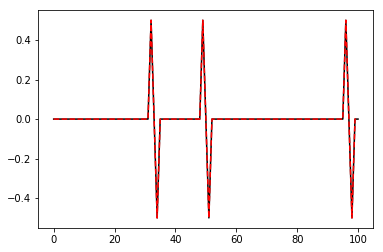

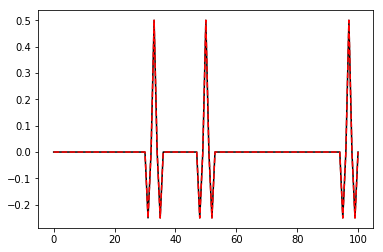

In [2]:
nx = 101
x = np.zeros(nx)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1

Dop = FirstDerivative(nx, edge=True)
Dconvop = Convolve1D(nx, np.array([0.5, 0, -0.5]), offset=1)

y = Dop*x
yconv = Dconvop*x

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

plt.figure()
plt.plot(y, 'k')
plt.plot(yconv, '--r')

plt.figure()
plt.plot(xadj, 'k')
plt.plot(xadjconv, '--r');

In [3]:
%timeit -n 100 -r 3 Dop.matvec(x)
%timeit -n 100 -r 3 Dconvop.matvec(x)

%timeit -n 100 -r 3 Dop.rmatvec(y)
%timeit -n 100 -r 3 Dconvop.rmatvec(y)

32.5 µs ± 10.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
30.5 µs ± 3.72 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
31.1 µs ± 5.73 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
23.8 µs ± 3.56 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


## 2D

In [4]:
nt, nx = 501, 1001 
x = np.zeros((nt, nx))
x[nt//2] = 1
x[nt//3] = 1
x[nt-4] = 1

Dop = FirstDerivative(nx*nt, dims=(nt, nx), dir=0)
Dconvop = Convolve1D(nx*nt, np.array([0.5, 0, -0.5]), dims=(nt, nx), offset=1, dir=0)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [5]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

8.8 ms ± 308 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
16.5 ms ± 795 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
11.5 ms ± 423 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
13.6 ms ± 910 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [6]:
nt, nx = 501, 1001 
x = np.zeros((nt, nx))
x[:, nx//2] = 1
x[:, nx//3] = 1
x[:, nx-4] = 1

Dop = FirstDerivative(nx*nt, dims=(nt, nx), dir=1)
Dconvop = Convolve1D(nx*nt, np.array([0.5, 0, -0.5]), dims=(nt, nx), offset=1, dir=1)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [7]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

21.3 ms ± 3.91 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
16 ms ± 587 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
20.8 ms ± 765 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
14.1 ms ± 62.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## 3D

In [8]:
nt, nx, ny = 101, 201, 101
x = np.zeros((nt, nx, ny))
x[...,ny//2] = 1
x[...,ny//3] = 1
x[...,ny-4] = 1

Dop = FirstDerivative(nx*nt*ny, dims=(nt, nx, ny), dir=2)
Dconvop = Convolve1D(nx*nt*ny, np.array([0.5, 0, -0.5]), 
                     dims=(nt, nx, ny), offset=1, dir=2)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [9]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

80.5 ms ± 6.09 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
72.1 ms ± 1.6 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
115 ms ± 6.25 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
62.3 ms ± 3.61 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
